<a href="https://colab.research.google.com/github/isj0/DeepLearning/blob/main/Project_02_UC_Merced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install required libraries - Captum
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 123.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requ

In [ ]:
# importing basic libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from PIL import Image
from captum.attr import IntegratedGradients, Saliency
from captum.attr import visualization as viz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# device set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


### a) Design a deep neural network (DNN) (at least 3 fully connected neural network) for the UC-Merced dataset

In [ ]:
# path to images folder
images_path = "/content/drive/MyDrive/Project 02/UCMerced_LandUse/Images"

# list of class names
classes = sorted(os.listdir(images_path))

# check how many images in each class
for cls in classes:
    cls_path = os.path.join(images_path, cls)
    num_images = len(os.listdir(cls_path))
    print(f"{cls}: {num_images} images")

agricultural: 100 images
airplane: 100 images
baseballdiamond: 100 images
beach: 100 images
buildings: 100 images
chaparral: 100 images
denseresidential: 100 images
forest: 100 images
freeway: 100 images
golfcourse: 100 images
harbor: 100 images
intersection: 100 images
mediumresidential: 100 images
mobilehomepark: 100 images
overpass: 100 images
parkinglot: 100 images
river: 100 images
runway: 100 images
sparseresidential: 100 images
storagetanks: 100 images
tenniscourt: 100 images


In [ ]:
# Preprocess images - defining transformations

transform = transforms.Compose([
    # resize all images to 64 x 64
    transforms.Resize((64, 64)),
    # convert images to Pytorch tensors
    transforms.ToTensor(),
    # normalize RGB channels
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=images_path, transform=transform)

In [ ]:
# splitting dataset into training and testing sets (80% for training & 20% for testing)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# now create dataloaders for batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# check dataset info
print(f"Total number of images: {len(dataset)}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

Total number of images: 2100
Number of training images: 1680
Number of testing images: 420
Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


Batch shape: torch.Size([32, 3, 64, 64])
Labels shape: torch.Size([32])



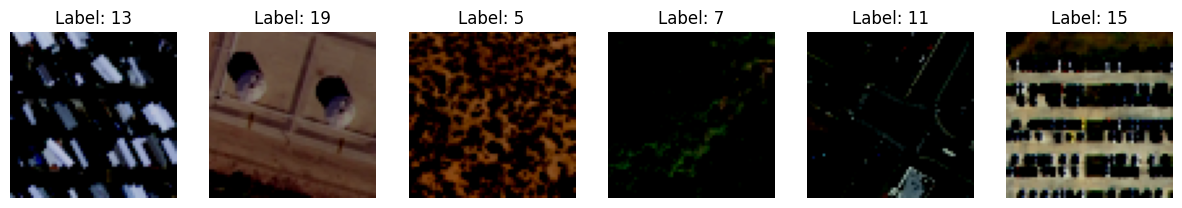

In [ ]:
# check the first batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print()

# display first 6 images in the batch
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

for i in range(6):
    img = images[i].numpy().transpose((1, 2, 0))
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()


In [ ]:
# defining DNN model

class UC_DNN(nn.Module):
    def __init__(self, num_classes):
        super(UC_DNN, self).__init__()

        # fully connected layers
        # Input to 1st layer with 512 neurons
        self.fc1 = nn.Linear(64 * 64 * 3, 512)
        # 2nd layer with 256 neurons
        self.fc2 = nn.Linear(512, 256)
        # 3rd layer with 128 neurons
        self.fc3 = nn.Linear(256, 128)
        # output layer with number of classes
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        # flatten the input to 1D vector
        x = x.view(x.size(0), -1)

        # now apply fully connected layers with Relu activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x



In [ ]:
# model parameters
input_size = 64 * 64 * 3
num_classes = len(dataset.classes)

# create model and display its info
model_dnn = UC_DNN(num_classes)
print(model_dnn)

UC_DNN(
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=21, bias=True)
)


In [ ]:
# calculate accuracy

def calculate_accuracy(y_pred, y_true):
    # class with the highest probability
    predicted = torch.argmax(y_pred, dim = 1)

    # count correct predictions
    correct = (predicted == y_true).sum().item()

    return correct / len(y_true)

In [ ]:
# training function - train one full pass through training batches

def train_one_epoch(model, dataloader, loss_fn, optimizer):
    # set model to training mode
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in dataloader:
        # move the data to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)

        # calculate loss
        loss = loss_fn(outputs, labels)

        # backward pass and optimzation
        optimizer.zero_grad()
        loss.backward()     # compute gradients
        optimizer.step()    # update weights

        # update running metrics
        running_loss += loss.item()
        running_acc += calculate_accuracy(outputs, labels)

    # return average loss and accuracy
    return running_loss / len(dataloader), running_acc / len(dataloader)

In [ ]:
# testing function to check accuracy and loss on test set

def evaluate(model, dataloader, loss_fn):
    # set model to evaluation mode
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    # disable gradient computation
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            running_acc += calculate_accuracy(outputs, labels)

    return running_loss / len(dataloader), running_acc / len(dataloader)

In [ ]:
# create model, loss and optimizer

# move model to GPU
model_dnn = model_dnn.to(device)

# define loss function - this is for multi class classification
loss_fn_dnn = nn.CrossEntropyLoss()

# Adam optimizer to update weights during training
optimizer_dnn = optim.Adam(model_dnn.parameters(), lr = 0.001)

In [ ]:
# Train the model for several epochs

train_acc_list_dnn = []
test_acc_list_dnn = []

# full passes through training dataset
EPOCHS =10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model_dnn, train_loader, loss_fn_dnn, optimizer_dnn)
    test_loss, test_acc = evaluate(model_dnn, test_loader, loss_fn_dnn)

    # record train/test accuracies for each epoch
    train_acc_list_dnn.append(train_acc)
    test_acc_list_dnn.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")

Epoch 1/10
Train Loss: 2.7223, Train Accuracy: 0.1863
Test Loss: 2.5241, Test Accuracy: 0.2232
-----------------------------------------------------
Epoch 2/10
Train Loss: 2.0873, Train Accuracy: 0.3620
Test Loss: 2.3247, Test Accuracy: 0.2946
-----------------------------------------------------
Epoch 3/10
Train Loss: 1.5490, Train Accuracy: 0.5295
Test Loss: 2.2187, Test Accuracy: 0.3750
-----------------------------------------------------
Epoch 4/10
Train Loss: 1.0491, Train Accuracy: 0.6875
Test Loss: 2.4241, Test Accuracy: 0.3594
-----------------------------------------------------
Epoch 5/10
Train Loss: 0.7076, Train Accuracy: 0.7942
Test Loss: 2.5572, Test Accuracy: 0.3460
-----------------------------------------------------
Epoch 6/10
Train Loss: 0.5132, Train Accuracy: 0.8426
Test Loss: 3.3368, Test Accuracy: 0.3371
-----------------------------------------------------
Epoch 7/10
Train Loss: 0.3853, Train Accuracy: 0.8833
Test Loss: 3.3520, Test Accuracy: 0.4040
-----------

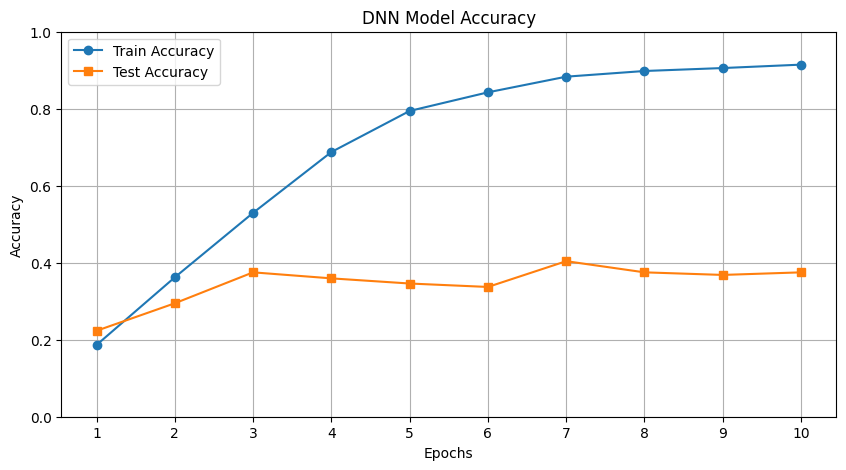

In [ ]:
# plot train/test accuracy over epochs

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_acc_list_dnn, marker='o', label = "Train Accuracy")
plt.plot(range(1, EPOCHS+1), test_acc_list_dnn, marker='s', label = "Test Accuracy")
plt.title("DNN Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(1, EPOCHS+1))
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# visualize predictions

# get a batch of test images
images, labels = next(iter(test_loader))

# move to GPU
images = images.to(device)
labels = labels.to(device)

# make predictions -
# set model to evaluation mode
model_dnn.eval()

with torch.no_grad():
    outputs = model_dnn(images)
    # predicted class for each image
    _, preds = torch.max(outputs, 1)


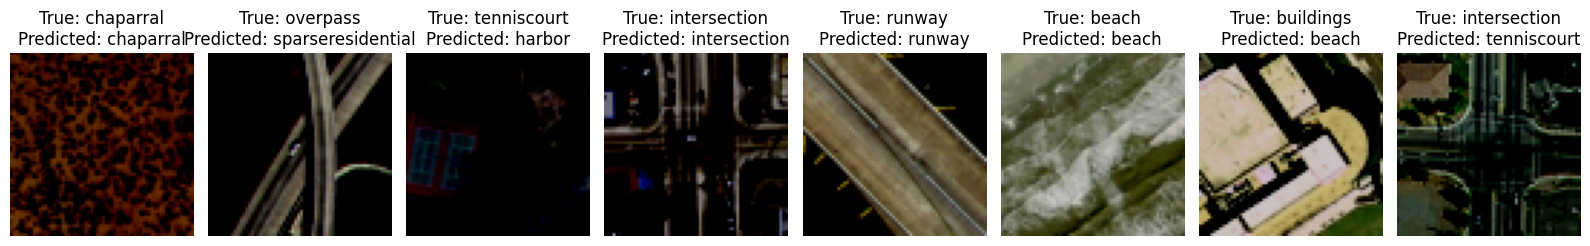

In [ ]:
# visualize some images with predictions

# show first 8 images
fig, axes = plt.subplots(1, 8, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    axes[i].imshow(img)
    img = (img * 0.5) + 0.5
    axes[i].set_title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Confusion matrix

def plot_confusion_matrix(model, test_loader, class_names, title = "Confusion Matrix"):

    # model must be in evaluation mode
    model.eval()

    # list to store all predictions and true labels
    all_preds = []
    all_labels = []

    # disable gradient computation
    with torch.no_grad():
        for images, labels in test_loader:
            # move images and labels to GPU
            images = images.to(device)
            labels = labels.to(device)

            # forward pass: get the model outputs
            outputs = model(images)

            # get the predicted class
            _, preds = torch.max(outputs, 1)

            # store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # compute confusion matrix using sklearn
    cm = confusion_matrix(all_labels, all_preds)

    # display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(title)
    plt.show()


In [ ]:
# Evaluate test accuracy and plot confusion matrix

def evaluate_and_plot(model, test_loader, classes, title="Confusion Matrix"):

    # calculate test loss & acccuracy
    loss_fn = nn.CrossEntropyLoss()
    test_loss, test_acc = evaluate(model, test_loader, loss_fn)

    # display test accuracy and loss
    print(f"Test Accuracy for {title}: {test_acc*100:.2f}")
    print(f"Test Loss for {title}: {test_loss:.4f}")

    # now lets plot the confusion matrix
    plot_confusion_matrix(model, test_loader, classes, title)

Test Accuracy for DNN: 37.50
Test Loss for DNN: 3.8537


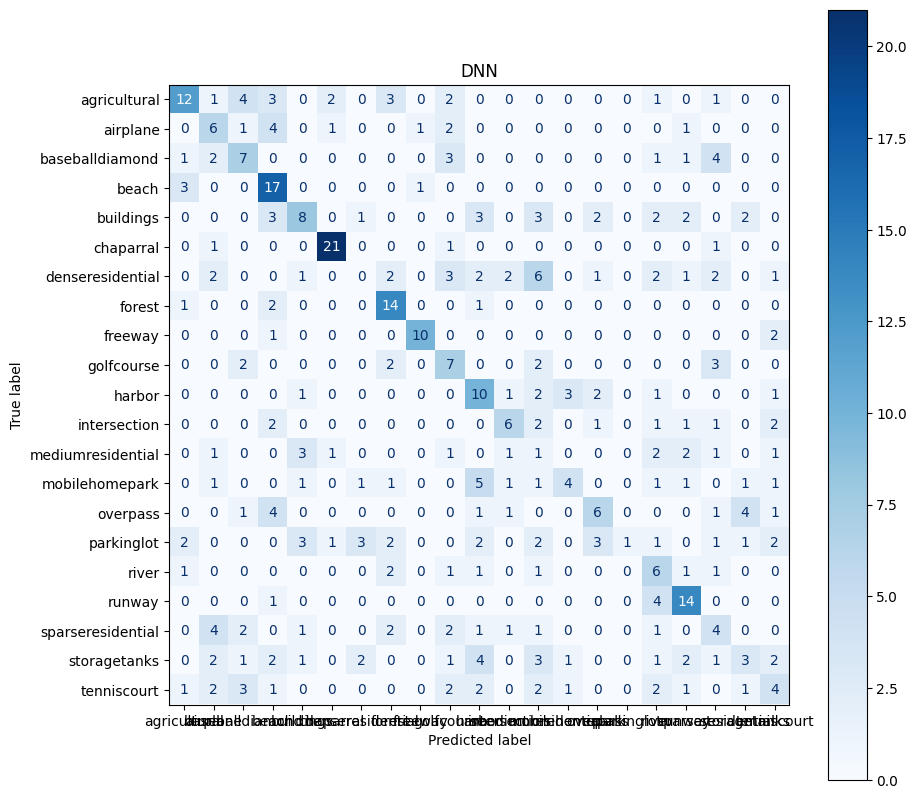

In [ ]:
# Evaluate DNN test set- print test accuracy, loss,print confusion matrix

evaluate_and_plot(model_dnn, test_loader, classes, "DNN")

In [ ]:
# Save the model weights
torch.save(model_dnn.state_dict(), "ucmerced_dnn.pth")
print("DNN model saved as ucmerced_dnn.pth")

DNN model saved as ucmerced_dnn.pth


### b) Design a deep convolutions neural network (DCNN) with 4 convolutional layers for the UC-Merced dataset

In [ ]:
# CNN Model

class UC_CNN(nn.Module):
    def __init__(self, num_classes):
        super(UC_CNN, self).__init__()

        # convolutional block  1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # convolutional block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes) # output for UC Merced classes
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



In [ ]:
# create model, loss and optimizer
# model parameters
num_classes = len(dataset.classes)

cnn_model = UC_CNN(num_classes)

# move model to GPU
cnn_model = cnn_model.to(device)

# define loss function - this is for multi class classification
loss_fn_cnn = nn.CrossEntropyLoss()

# Adam optimizer to update weights during training
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr = 0.001)

In [ ]:
# Train CNN for several epochs

train_acc_list_cnn = []
test_acc_list_cnn = []

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(cnn_model, train_loader, loss_fn_cnn, optimizer_cnn)
    test_loss, test_acc = evaluate(cnn_model, test_loader, loss_fn_cnn)

    # record train/test accuracies for each epoch
    train_acc_list_cnn.append(train_acc)
    test_acc_list_cnn.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")

Epoch 1/10
Train Loss: 3.2668, Train Accuracy: 0.1002
Test Loss: 2.7721, Test Accuracy: 0.1429
-----------------------------------------------------
Epoch 2/10
Train Loss: 2.6174, Train Accuracy: 0.1958
Test Loss: 2.1689, Test Accuracy: 0.3549
-----------------------------------------------------
Epoch 3/10
Train Loss: 2.3034, Train Accuracy: 0.2612
Test Loss: 2.0721, Test Accuracy: 0.3482
-----------------------------------------------------
Epoch 4/10
Train Loss: 2.0506, Train Accuracy: 0.3420
Test Loss: 1.7356, Test Accuracy: 0.4397
-----------------------------------------------------
Epoch 5/10
Train Loss: 1.9258, Train Accuracy: 0.3667
Test Loss: 1.8479, Test Accuracy: 0.4241
-----------------------------------------------------
Epoch 6/10
Train Loss: 1.8263, Train Accuracy: 0.4145
Test Loss: 1.6067, Test Accuracy: 0.5179
-----------------------------------------------------
Epoch 7/10
Train Loss: 1.6833, Train Accuracy: 0.4540
Test Loss: 1.4565, Test Accuracy: 0.5179
-----------

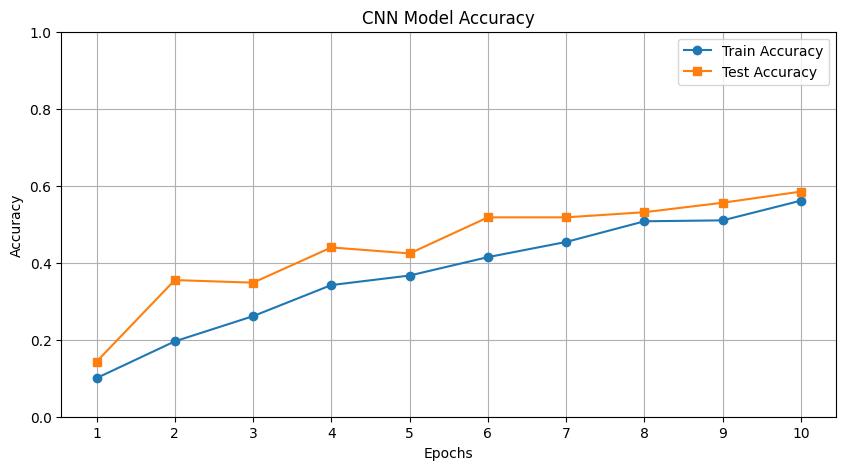

In [ ]:
# plot train/test accuracy over epochs

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_acc_list_cnn, marker='o', label = "Train Accuracy")
plt.plot(range(1, EPOCHS+1), test_acc_list_cnn, marker='s', label = "Test Accuracy")
plt.title("CNN Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(1, EPOCHS+1))
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# visualize predictions

# get a batch of test images
images, labels = next(iter(test_loader))

# move to GPU
images = images.to(device)
labels = labels.to(device)

# make predictions -
# set model to evaluation mode
cnn_model.eval()

with torch.no_grad():
    outputs = cnn_model(images)
    # predicted class for each image
    _, preds = torch.max(outputs, 1)

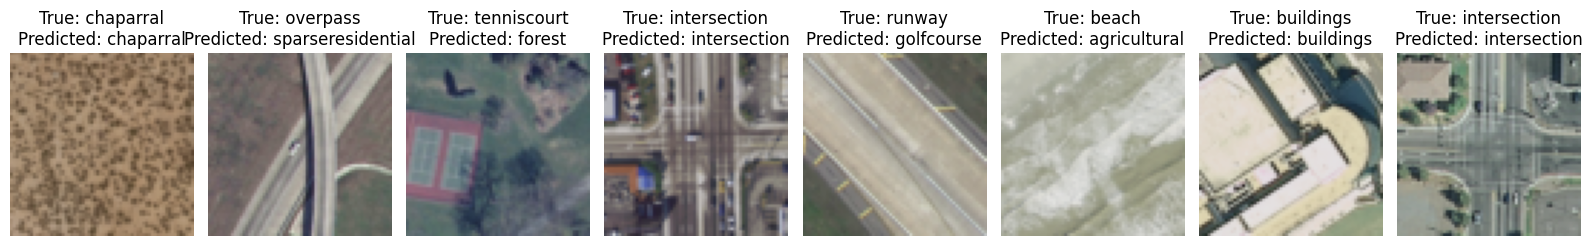

In [ ]:
# visualize some images with predictions

# show first 8 images
fig, axes = plt.subplots(1, 8, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    img = (img * 0.5) + 0.5
    axes[i].imshow(img)
    axes[i].set_title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Test Accuracy for CNN: 58.48
Test Loss for CNN: 1.2711


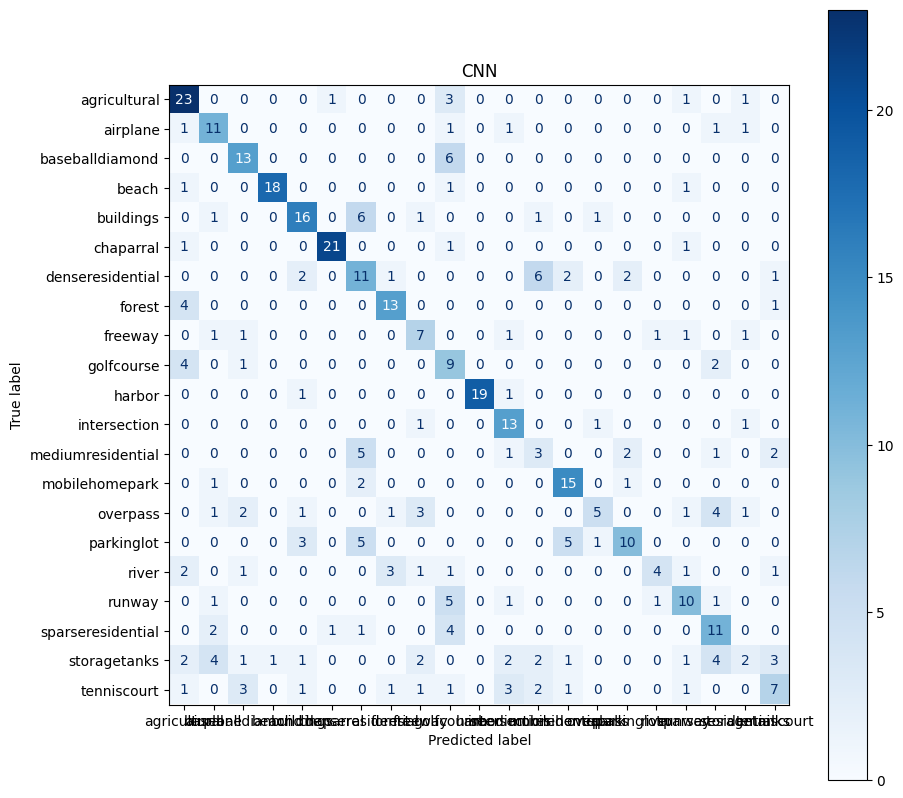

In [ ]:
# Evalute CNN test set- print test accuracy, loss and confusion matrix

evaluate_and_plot(cnn_model, test_loader, classes, "CNN")

In [ ]:
# Save the model weights
torch.save(cnn_model.state_dict(), "ucmerced_cnn.pth")
print("CNN model saved as ucmerced_cnn.pth")


CNN model saved as ucmerced_cnn.pth


### c) Try to improve the performance of the DNN and DCNN by using transfer learning, data augmentation techniques

In [ ]:
# data augmentation

# defining transformation for training
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# defining transformation for testing images
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
# load UC-MERCED dataset
full_dataset = datasets.ImageFolder(root=images_path)

# split the indices for train/test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_indices, test_indices = torch.utils.data.random_split(range(len(full_dataset)), [train_size, test_size])

# creating subsets
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# assigning transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# now create dataloaders for batches
train_loader_aug = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_aug = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# initialize DNN, loss function and optimizer for augmented dataset

model_dnn_aug = UC_DNN(num_classes).to(device)
loss_fn_dnn_aug = nn.CrossEntropyLoss()
optimizer_dnn = optim.Adam(model_dnn_aug.parameters(), lr=0.001)

# full passes through training dataset as before
EPOCHS =10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model_dnn_aug, train_loader_aug, loss_fn_dnn_aug, optimizer_dnn)
    test_loss, test_acc = evaluate(model_dnn_aug, test_loader_aug, loss_fn_dnn_aug)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")

# save augmented model weights
torch.save(model_dnn_aug.state_dict(), "ucmerced_dnn_aug.pth")
print("DNN model with augmentation saved as ucmerced_dnn_aug.pth")

Epoch 1/10
Train Loss: 2.6993, Train Accuracy: 0.1999
Test Loss: 2.5506, Test Accuracy: 0.2500
-----------------------------------------------------
Epoch 2/10
Train Loss: 2.0405, Train Accuracy: 0.3903
Test Loss: 2.3757, Test Accuracy: 0.2946
-----------------------------------------------------
Epoch 3/10
Train Loss: 1.5336, Train Accuracy: 0.5401
Test Loss: 2.3676, Test Accuracy: 0.3661
-----------------------------------------------------
Epoch 4/10
Train Loss: 1.0915, Train Accuracy: 0.6704
Test Loss: 2.4234, Test Accuracy: 0.3661
-----------------------------------------------------
Epoch 5/10
Train Loss: 0.8222, Train Accuracy: 0.7618
Test Loss: 2.7595, Test Accuracy: 0.3750
-----------------------------------------------------
Epoch 6/10
Train Loss: 0.5487, Train Accuracy: 0.8402
Test Loss: 3.1946, Test Accuracy: 0.3594
-----------------------------------------------------
Epoch 7/10
Train Loss: 0.4023, Train Accuracy: 0.8779
Test Loss: 3.5440, Test Accuracy: 0.3460
-----------

Test Accuracy for DNN with Augmentation: 38.39
Test Loss for DNN with Augmentation: 4.1041


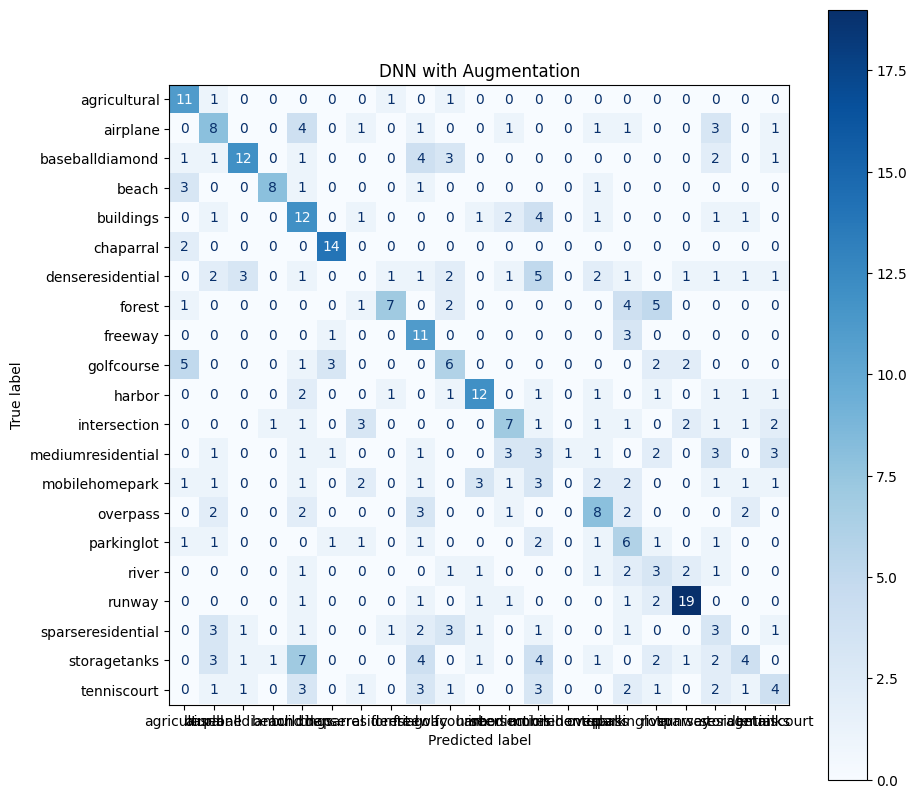

In [ ]:
# Evaluate DNN aug test set- print test accuracy,loss and print confusion matrix

evaluate_and_plot(model_dnn_aug, test_loader_aug, classes, "DNN with Augmentation")

In [ ]:
# initialize CNN, loss function and optimizer for augmented dataset

model_cnn_aug = UC_CNN(num_classes).to(device)
loss_fn_cnn_aug = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn_aug.parameters(), lr=0.001)

# full passes through training dataset as before
EPOCHS =10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model_cnn_aug, train_loader_aug, loss_fn_cnn_aug, optimizer_cnn)
    test_loss, test_acc = evaluate(model_cnn_aug, test_loader_aug, loss_fn_cnn_aug)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")

# save model weights
torch.save(model_cnn_aug.state_dict(), "ucmerced_cnn_aug.pth")
print("CNN model with augmentation saved as ucmerced_cnn_aug.pth")

Epoch 1/10
Train Loss: 3.1138, Train Accuracy: 0.1468
Test Loss: 2.6260, Test Accuracy: 0.1853
-----------------------------------------------------
Epoch 2/10
Train Loss: 2.3695, Train Accuracy: 0.2588
Test Loss: 2.1225, Test Accuracy: 0.2924
-----------------------------------------------------
Epoch 3/10
Train Loss: 2.1051, Train Accuracy: 0.3426
Test Loss: 1.9401, Test Accuracy: 0.3237
-----------------------------------------------------
Epoch 4/10
Train Loss: 1.8983, Train Accuracy: 0.3868
Test Loss: 1.8566, Test Accuracy: 0.3705
-----------------------------------------------------
Epoch 5/10
Train Loss: 1.8077, Train Accuracy: 0.4151
Test Loss: 1.6368, Test Accuracy: 0.4799
-----------------------------------------------------
Epoch 6/10
Train Loss: 1.6502, Train Accuracy: 0.4658
Test Loss: 1.6613, Test Accuracy: 0.4799
-----------------------------------------------------
Epoch 7/10
Train Loss: 1.4737, Train Accuracy: 0.5212
Test Loss: 1.6439, Test Accuracy: 0.4955
-----------

Test Accuracy for CNN with Augmentation: 57.37
Test Loss for CNN with Augmentation: 1.2947


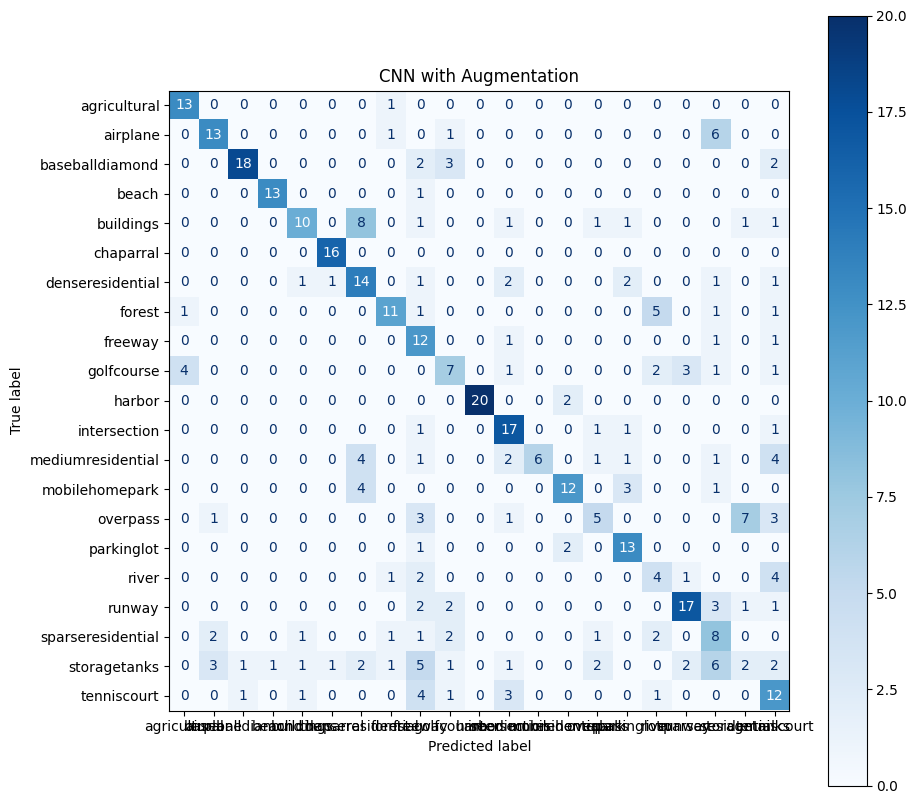

In [ ]:
# Evaluate CNN aug test set- print test accuracy,loss and print confusion matrix

evaluate_and_plot(model_cnn_aug, test_loader_aug, classes, "CNN with Augmentation")

In [ ]:
# Transfer Learning

# load a pretrained Resnet-18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# replacing the output layer
num_classes = len(dataset.classes)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# move to device
resnet = resnet.to(device)

# define loss function and optimizer
loss_fn_res = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(resnet.fc.parameters(), lr = 0.001)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [ ]:

# transforms for ResNet
train_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# datasets & dataloaders for ResNet
full_dataset_resnet = datasets.ImageFolder(root=images_path)

# split indices for same as before for consistent train/test split
train_dataset_resnet = torch.utils.data.Subset(full_dataset_resnet, train_indices)
test_dataset_resnet = torch.utils.data.Subset(full_dataset_resnet, test_indices)

# assign resnet transforms
train_dataset_resnet.dataset.transform = train_transform_resnet
test_dataset_resnet.dataset.transform = test_transform_resnet

# creating dataloaders
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=32, shuffle=False)

In [ ]:
# Resnet Training using resnet dataloaders
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(resnet, train_loader_resnet, loss_fn_res, optimizer_res)
    test_loss, test_acc = evaluate(resnet, test_loader_resnet, loss_fn_res)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")

torch.save(resnet.state_dict(), "uc_merced_resnet.pth")

Epoch 1/10
Train Loss: 2.2347, Train Accuracy: 0.4121
Test Loss: 1.4302, Test Accuracy: 0.6853
-----------------------------------------------------
Epoch 2/10
Train Loss: 1.0508, Train Accuracy: 0.8101
Test Loss: 0.8959, Test Accuracy: 0.8259
-----------------------------------------------------
Epoch 3/10
Train Loss: 0.7011, Train Accuracy: 0.8738
Test Loss: 0.6301, Test Accuracy: 0.8929
-----------------------------------------------------
Epoch 4/10
Train Loss: 0.5175, Train Accuracy: 0.9086
Test Loss: 0.5055, Test Accuracy: 0.9129
-----------------------------------------------------
Epoch 5/10
Train Loss: 0.4324, Train Accuracy: 0.9204
Test Loss: 0.4333, Test Accuracy: 0.9196
-----------------------------------------------------
Epoch 6/10
Train Loss: 0.3633, Train Accuracy: 0.9316
Test Loss: 0.3784, Test Accuracy: 0.9330
-----------------------------------------------------
Epoch 7/10
Train Loss: 0.3071, Train Accuracy: 0.9481
Test Loss: 0.3580, Test Accuracy: 0.9107
-----------

Test Accuracy for Resnet Transfer Learning: 93.75
Test Loss for Resnet Transfer Learning: 0.3048


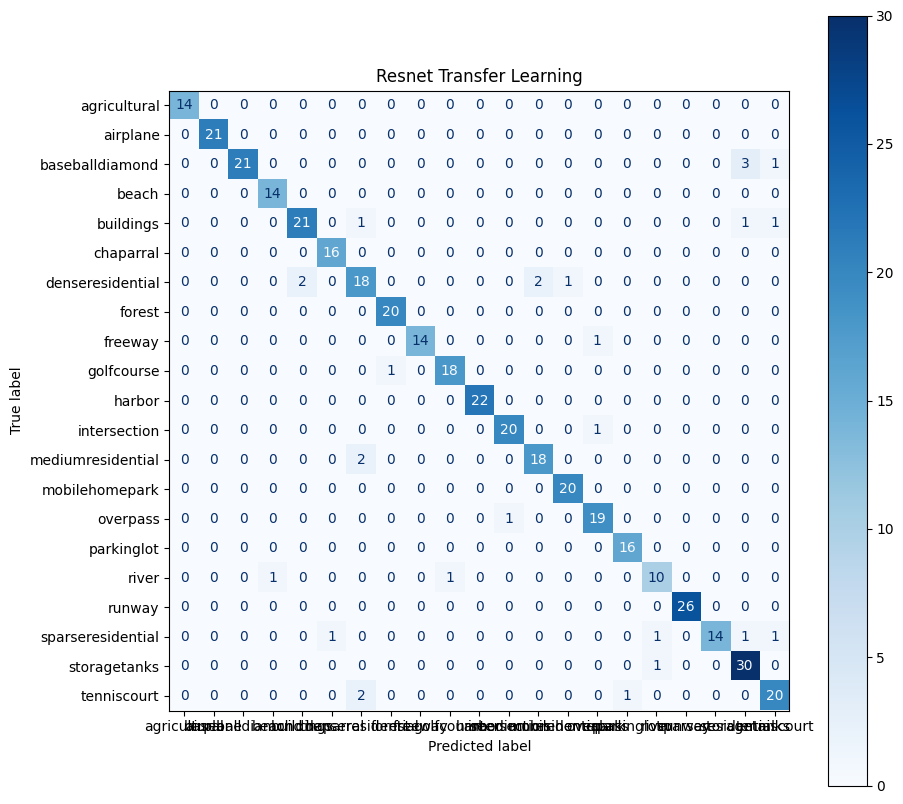

In [ ]:
# Evaluate Resnet test set- print test accuracy,loss and print confusion matrix

evaluate_and_plot(resnet, test_loader_resnet, classes, "Resnet Transfer Learning")

### d) Interpret the learned model decision using Captum or another library. You can use samples of multiple classes to show the learned deep learning model decision.

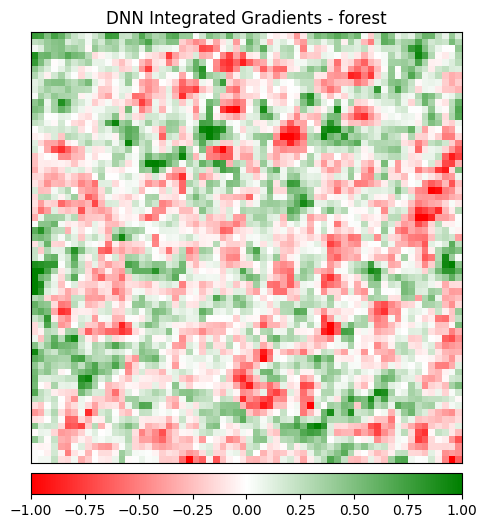

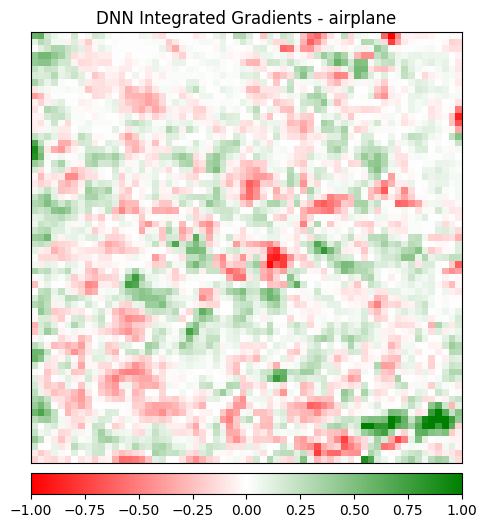

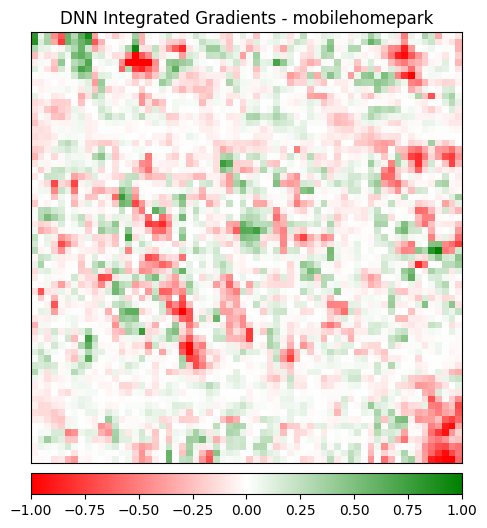

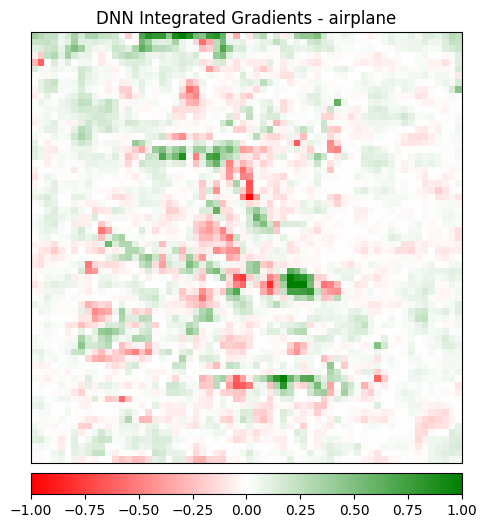

In [ ]:
# DNN transfer learning model with Integrated Gradients

# put DNN model in evaluation model
model_dnn_aug.eval()

# get a batch of test images
images, labels = next(iter(test_loader_aug))
# move images to GPU
images, labels = images.to(device), labels.to(device)


# initialize Captum Integrated Grandients with the trained DNN model
ig = IntegratedGradients(model_dnn_aug)

for i in range(4):

    # selecting one images and target class
    input_img = images[i].unsqueeze(0)
    target_class = labels[i].item()

    # compute IG attributions
    attributions, delta = ig.attribute(input_img, target=target_class, return_convergence_delta=True)

    # convert image and attributions
    img = input_img[0].cpu().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5
    attr = attributions[0].detach().cpu().numpy().transpose(1, 2, 0)

    # visualize attribution heat map
    viz.visualize_image_attr(attr, img, method="heat_map",
                            sign="all", show_colorbar=True,
                            title=f"DNN Integrated Gradients - {classes[target_class]}")


/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


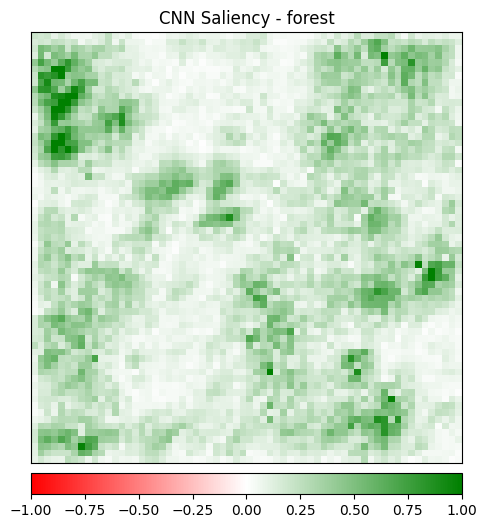

/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


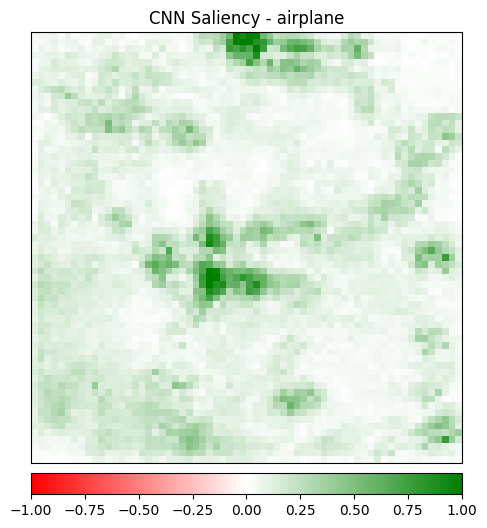

/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


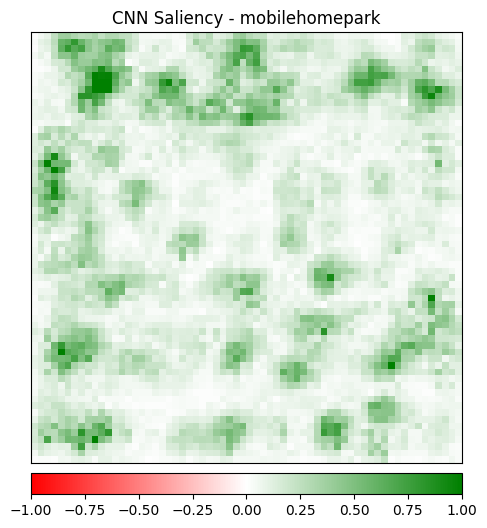

/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


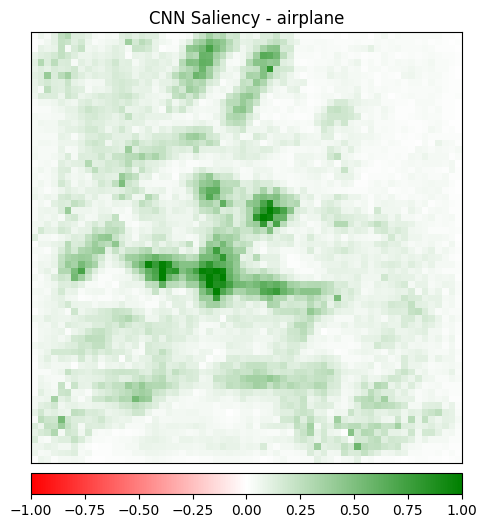

In [ ]:
# CNN transfer learning model with Saliency maps

# put CNN model in evaluation mode
model_cnn_aug.eval()

# get a batch of test images
images, labels = next(iter(test_loader_aug))
# move images to GPU
images, labels = images.to(device), labels.to(device)

# initialize Captum saliency
saliency = Saliency(model_cnn_aug)

# for first 4 images

for i in range(4):

    input_img = images[i].unsqueeze(0)
    target_class = labels[i].item()

    # compute saliency map
    saliency_map = saliency.attribute(input_img, target=target_class)

    # convert image and saliency map to numpy
    img = input_img[0].cpu().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5
    saliency_map = saliency_map[0].detach().cpu().numpy().transpose(1, 2, 0)

    # visualize saliency map as heatmap
    viz.visualize_image_attr(saliency_map, img, method="heat_map",
                             sign = "all", show_colorbar = True,
                             title = f"CNN Saliency - {classes[target_class]}")


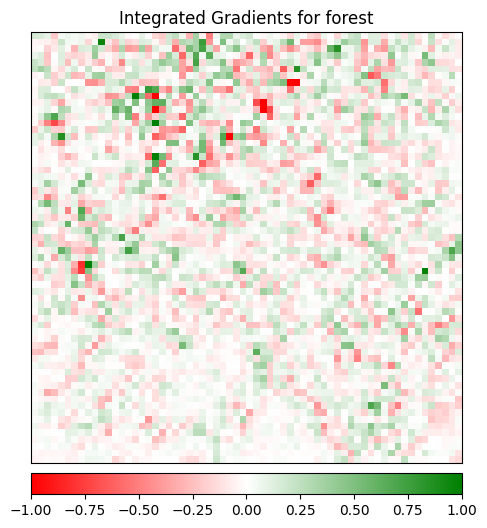

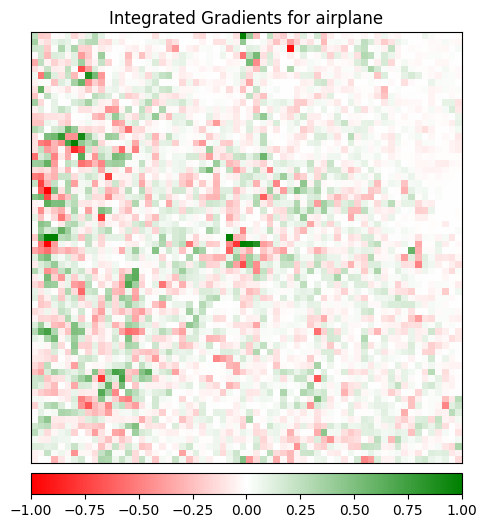

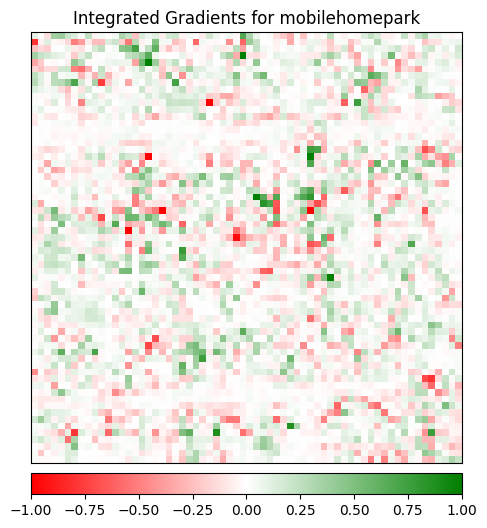

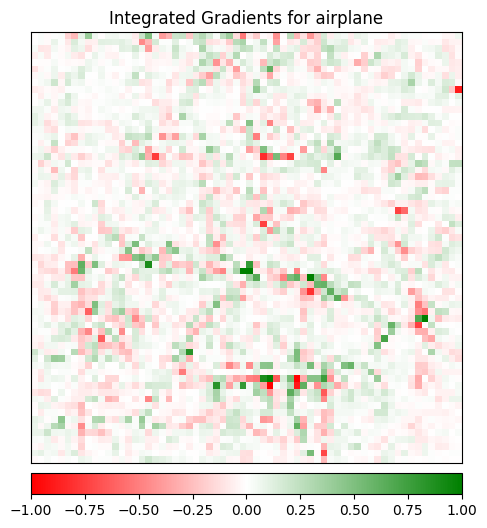

In [ ]:
# Resnet transfer learning model with Integrated Gradients
# resnet model in evaluation mode
resnet.eval()

# get a batch of test images
images, labels = next(iter(test_loader_resnet))
# move images to GPU
images, labels = images.to(device), labels.to(device)

# initialize the attribution method and pass the model to it
ig = IntegratedGradients(resnet)

# visualization with captum
for i in range(4):
    # pick an image and target class
    input_img = images[i].unsqueeze(0)
    target_class = labels[i].item()

    # compute attributions
    attributions, delta = ig.attribute(input_img, target=target_class, return_convergence_delta=True)

    # visualize attributions
    img = input_img[0].cpu().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5

    # convert attributions to numpy
    attr = attributions[0].detach().cpu().numpy().transpose(1, 2, 0)

    # visualize heatmap
    viz.visualize_image_attr(attr, img, method="heat_map", sign="all", title=f"Integrated Gradients for {classes[target_class]}", show_colorbar=True)
